# 📌 STEP 1: Data Preprocessing


In [2]:
# 📍 Normalize numerical features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load dataset
df = pd.read_csv('HousingData.csv')  # Ensure file is downloaded from: https://www.kaggle.com/datasets/altavish/boston-housing-dataset
print("Initial Data Sample:\n", df.head())

Initial Data Sample:
       CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90    NaN  36.2  


In [4]:
# Target variable
target = 'MEDV'
X = df.drop(columns=[target])
y = df[target]

In [5]:
# Normalize features using Min-Max Scaling
X_normalized = (X - X.min()) / (X.max() - X.min())

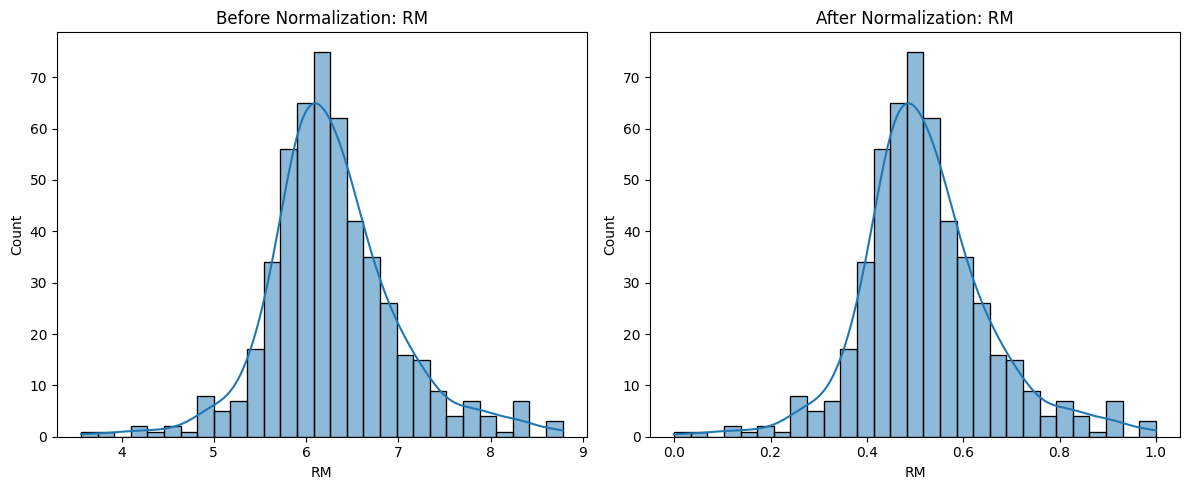

In [6]:
# Visualize distribution before and after normalization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['RM'], kde=True)
plt.title("Before Normalization: RM")

plt.subplot(1, 2, 2)
sns.histplot(X_normalized['RM'], kde=True)
plt.title("After Normalization: RM")
plt.tight_layout()
plt.show()

In [7]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normalized.values, y.values, test_size=0.2, random_state=42)


# 📌 STEP 2: Model Implementation


In [19]:
# Flatten and sanitize labels
y_train = y_train.flatten()
y_test = y_test.flatten()

# Check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Check for NaNs
print("NaNs in X_train?", np.isnan(X_train).sum())
print("NaNs in y_train?", np.isnan(y_train).sum())
print("Infs in X_train?", np.isinf(X_train).sum())
print("Infs in y_train?", np.isinf(y_train).sum())

# Fix: Replace NaNs and Infs with 0s
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)

# Confirm after cleaning
print("After cleaning:")
print("NaNs in X_train?", np.isnan(X_train).sum())
print("NaNs in y_train?", np.isnan(y_train).sum())
print("Infs in X_train?", np.isinf(X_train).sum())
print("Infs in y_train?", np.isinf(y_train).sum())


X_train shape: (404, 13)
y_train shape: (404,)
NaNs in X_train? 100
NaNs in y_train? 0
Infs in X_train? 0
Infs in y_train? 0
After cleaning:
NaNs in X_train? 0
NaNs in y_train? 0
Infs in X_train? 0
Infs in y_train? 0


In [21]:
class LinearRegressionScratch:
    def fit(self, X, y, lr=0.01, epochs=1000):
        self.m, self.n = X.shape
        self.weights = np.zeros(self.n)
        self.bias = 0

        for epoch in range(epochs):
            y_pred = np.dot(X, self.weights) + self.bias
            error = y_pred - y

            dw = (1/self.m) * np.dot(X.T, error)
            db = (1/self.m) * np.sum(error)

            # Debugging: Show mean of gradients
            print(f"Epoch {epoch} - dw mean: {np.mean(dw):.4f}, db: {db:.4f}")

            # Safety: Clip gradients
            dw = np.clip(dw, -10, 10)
            db = np.clip(db, -10, 10)

            self.weights -= lr * dw
            self.bias -= lr * db

            # Safety check
            if np.isnan(self.weights).any() or np.isnan(self.bias):
                print(f"NaNs detected at epoch {epoch}. Stopping training.")
                break

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


In [22]:
# 📍 Random Forest from Scratch (Simplified)
from collections import Counter

class DecisionTree:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth

    def fit(self, X, y, depth=0):
        if len(set(y)) == 1 or depth == self.max_depth:
            self.value = np.mean(y)
            return

        self.feature_index, self.threshold = self.best_split(X, y)
        if self.feature_index is None:
            self.value = np.mean(y)
            return

        left_idx = X[:, self.feature_index] < self.threshold
        right_idx = X[:, self.feature_index] >= self.threshold

        self.left = DecisionTree(self.max_depth)
        self.right = DecisionTree(self.max_depth)
        self.left.fit(X[left_idx], y[left_idx], depth + 1)
        self.right.fit(X[right_idx], y[right_idx], depth + 1)

    def best_split(self, X, y):
        best_mse = float("inf")
        best_idx, best_thresh = None, None
        for idx in range(X.shape[1]):
            for t in np.unique(X[:, idx]):
                left_y = y[X[:, idx] < t]
                right_y = y[X[:, idx] >= t]
                if len(left_y) == 0 or len(right_y) == 0:
                    continue
                mse = np.mean((left_y - left_y.mean())**2) + np.mean((right_y - right_y.mean())**2)
                if mse < best_mse:
                    best_mse = mse
                    best_idx, best_thresh = idx, t
        return best_idx, best_thresh

    def predict_row(self, row):
        if hasattr(self, 'value'):
            return self.value
        if row[self.feature_index] < self.threshold:
            return self.left.predict_row(row)
        else:
            return self.right.predict_row(row)

    def predict(self, X):
        return np.array([self.predict_row(row) for row in X])

class RandomForest:
    def __init__(self, n_estimators=10, max_depth=5):
        self.n_estimators = n_estimators
        self.max_depth = max_depth

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            idxs = np.random.choice(len(X), len(X))
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X[idxs], y[idxs])
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(predictions, axis=0)

In [23]:
# 📍 XGBoost from Scratch (Simplified)
class XGBoost:
    def __init__(self, n_estimators=10, max_depth=3, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.lr = learning_rate

    def fit(self, X, y):
        self.models = []
        pred = np.zeros(len(y))

        for _ in range(self.n_estimators):
            residual = y - pred
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X, residual)
            pred += self.lr * tree.predict(X)
            self.models.append(tree)

    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for tree in self.models:
            pred += self.lr * tree.predict(X)
        return pred

# 📌 STEP 3: Performance Comparison


In [24]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"{name} - RMSE: {rmse:.3f}, R2: {r2:.3f}")
    return rmse, r2, y_pred

results = {}
print("\nModel Evaluation:\n")
lr_model = LinearRegressionScratch()
results['Linear Regression'] = evaluate_model("Linear Regression", lr_model, X_train, y_train, X_test, y_test)

rf_model = RandomForest(n_estimators=10, max_depth=5)
results['Random Forest'] = evaluate_model("Random Forest", rf_model, X_train, y_train, X_test, y_test)

xgb_model = XGBoost(n_estimators=10, max_depth=3, learning_rate=0.1)
results['XGBoost'] = evaluate_model("XGBoost", xgb_model, X_train, y_train, X_test, y_test)


Model Evaluation:

Epoch 0 - dw mean: -8.2392, db: -22.7965
Epoch 1 - dw mean: -8.0365, db: -22.2834
Epoch 2 - dw mean: -7.8355, db: -21.7744
Epoch 3 - dw mean: -7.6363, db: -21.2693
Epoch 4 - dw mean: -7.4387, db: -20.7682
Epoch 5 - dw mean: -7.2428, db: -20.2709
Epoch 6 - dw mean: -7.0486, db: -19.7776
Epoch 7 - dw mean: -6.8560, db: -19.2881
Epoch 8 - dw mean: -6.6650, db: -18.8023
Epoch 9 - dw mean: -6.4756, db: -18.3204
Epoch 10 - dw mean: -6.2880, db: -17.8424
Epoch 11 - dw mean: -6.1026, db: -17.3699
Epoch 12 - dw mean: -5.9195, db: -16.9029
Epoch 13 - dw mean: -5.7395, db: -16.4434
Epoch 14 - dw mean: -5.5630, db: -15.9924
Epoch 15 - dw mean: -5.3898, db: -15.5499
Epoch 16 - dw mean: -5.2201, db: -15.1156
Epoch 17 - dw mean: -5.0537, db: -14.6893
Epoch 18 - dw mean: -4.8905, db: -14.2710
Epoch 19 - dw mean: -4.7304, db: -13.8605
Epoch 20 - dw mean: -4.5735, db: -13.4576
Epoch 21 - dw mean: -4.4196, db: -13.0621
Epoch 22 - dw mean: -4.2687, db: -12.6739
Epoch 23 - dw mean: -4.1

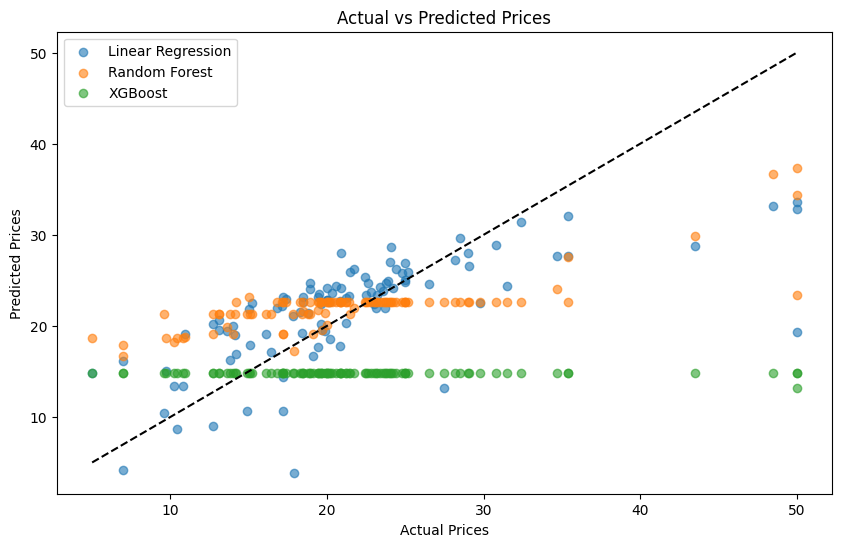

In [25]:
# 📊 Visualization of Predictions
plt.figure(figsize=(10, 6))
for name, (_, _, pred) in results.items():
    plt.scatter(y_test, pred, label=name, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.show()

# 📌 STEP 4: Feature Importance (Tree-Based Models)


In [26]:

def feature_importance(tree, feature_names, importance=None):
    if importance is None:
        importance = np.zeros(len(feature_names))
    if hasattr(tree, 'value'):
        return importance
    importance[tree.feature_index] += 1
    feature_importance(tree.left, feature_names, importance)
    feature_importance(tree.right, feature_names, importance)
    return importance

# Use one tree from Random Forest for demo
importance_scores = feature_importance(rf_model.trees[0], X.columns)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance_scores
}).sort_values(by='Importance', ascending=False)

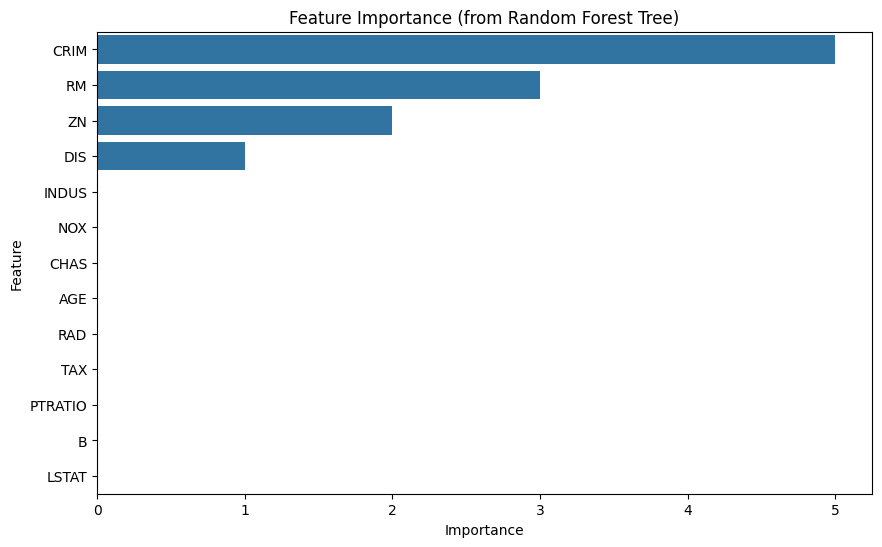

In [27]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance (from Random Forest Tree)")
plt.show()

# 📌 Final Model Selection


In [28]:
best_model = max(results.items(), key=lambda x: x[1][1])[0]
print(f"\n✅ Best Performing Model: {best_model}")


✅ Best Performing Model: Linear Regression
